# **RAFT Model Train**

In this notebook, we will train a model with the entire small RAFT as a backbone and convolutional layers to extract the speed data from the estimated flow at 1/8 resolution

In [1]:
import os
import sys
import time
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *
from dataset import MarsDataset

### Constants

In [3]:
ROOT = r"C:\Users\itber\Documents\datasets\mars_auto"
CHECKPOINT = r"C:\Users\itber\Documents\learning\self_tutorials\CV_projects\mars_challenge\models"
DEVICE = "cuda"
H, W = 540, 720 # standard image size

BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 5e-4

torch.backends.cudnn.benchmark = True

### Get Augmentations

Don't normalize anything since model already has normalization built into it's forward pass

In [4]:
import torchvision
from torchvision import transforms

train_transforms = transforms.Compose([
                                transforms.RandomResizedCrop((H, W), scale=(0.25, 1.0)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomVerticalFlip(0.1),
                                # transforms.RandomRotation((-10, 10))
                                ])

### Get Data with Random Splits

In [5]:
from torch.utils.data import DataLoader


train_dataset = MarsDataset(ROOT, transform=train_transforms, split='train')
valid_dataset = MarsDataset(ROOT, transform=None, split='valid')
test_dataset = MarsDataset(ROOT, transform=None, split='test')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=False)

### Check that dataloaders are working

In [6]:
(image1, image2), speed = next(iter(train_loader))
image1.min(), image1.max()

(tensor(0.), tensor(255.0000))

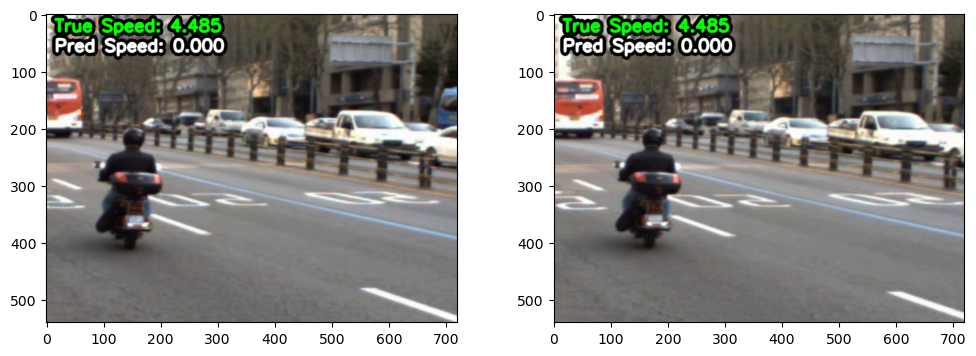

In [7]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(viz(image1[idx, :, :, :].squeeze(), speed[idx], 0))
ax[1].imshow(viz(image2[idx, :, :, :].squeeze(), speed[idx], 0))

In [8]:
train_dataset.image_path1, train_dataset.image_path2

('C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_1221.png',
 'C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_1222.png')

### Get Model

In [44]:
from RAFT.core.extractor import BottleneckBlock


class Network(nn.Module):
    def __init__(self, raft_model, freeze_raft=True, device='cuda'):
        super().__init__()

        self.raft_model = raft_model
        self.device = device

        self.bottle1 = BottleneckBlock(in_planes=2, planes=32, norm_fn='batch', stride=2).to(self.device)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=2, dilation=1, padding=0).to(self.device)
        self.norm1 = nn.BatchNorm2d(num_features=1)

        self.fc1 = nn.Linear(in_features=352, out_features=1).to(self.device)

        # freeze encoder weights
        if freeze_raft:
            for child in self.raft_model.children():
                for param in child.parameters():
                    param.requires_grad = False


    def forward(self, image1, image2):
        flow = self.raft_model(image1, image2, iters=1, flow_init=None, upsample=False, test_mode=True)[0]
        
        out = self.bottle1(flow)

        out = F.relu(self.norm1(self.conv1(out)))

        out = out.view(out.size()[0], -1)
        out = self.fc1(out)
        
        return out.squeeze()
        

In [45]:
raft_model = load_model("RAFT/models/raft-sintel.pth", args=Args())
model = Network(raft_model, freeze_raft=True).to("cuda")

In [46]:
model.eval();

In [47]:
# pad to ensure that it is divisible by 8
padder = InputPadder(image1.shape, mode=None)
image1, image2 = padder.pad(image1, image2)

In [48]:
out = model(image1.to("cuda"), image2.to("cuda"))

In [49]:
out.shape, speed.shape

(torch.Size([8]), torch.Size([8]))

### Training Utils

In [50]:

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, window_size=None):
        self.values = []
        self.length = len(self.values)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.values.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.round(self.sum / self.count, 4)

In [51]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

## Train Loop

In [52]:
model_root = r'C:\Users\itber\Documents\learning\self_tutorials\CV_projects\multitask_depth_seg\models'

model.to(DEVICE).train()

# scaling parameter for loss function
# c = 0.5

best_valid_loss = np.inf

avg_train_metrics = {
    'losses' : [],
}

avg_valid_metrics = {
    'losses' : [],
}


for e in range(EPOCHS):
    train_metrics = {
        'losses' : AverageMeter(),
    }

    model.train()

    for i, ((image1, image2), speed) in enumerate(train_loader):
        image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

        # pad to ensure that it is divisible by 8
        padder = InputPadder(image1.shape, mode=None)
        image1, image2 = padder.pad(image1, image2)

        # get predictions
        pred_speed = model(image1, image2)

        # compute losses
        loss = criterion(pred_speed, speed)

        # zero gradients 
        optimizer.zero_grad()

        # back prop loss
        loss.backward()

        # step weights
        optimizer.step()

        # store metrics
        train_metrics['losses'].update(loss.item())

        if i % 50 == 0:
            print(f"train: epoch {e} - iteration: {i} - MSE loss: {train_metrics['losses'].avg}") 
            
            # # cooldown
            # time.sleep(5)
    
    # save average metrics
    avg_train_metrics['losses'].append(np.round(train_metrics['losses'].avg, 3))


    # display train metrics
    print(f"train epoch {e} - avg MSE loss: {avg_train_metrics['losses'][-1]}")

    # validate model
    valid_metrics = {
        'losses' : AverageMeter()
    }

    model.eval()
    with torch.no_grad():
        for i, ((image1, image2), speed) in enumerate(valid_loader):
            image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

            # pad to ensure that it is divisible by 8
            padder = InputPadder(image1.shape, mode=None)
            image1, image2 = padder.pad(image1, image2)

            # get predictions
            pred_speed = model(image1, image2)

            # compute losses
            loss = criterion(pred_speed, speed)

            # store metrics
            valid_metrics['losses'].update(loss.item())

            if i % 50 == 0:
                print(f"valid: epoch {e} - MSE loss: {valid_metrics['losses'].avg}")

        # save average metrics
        avg_valid_metrics['losses'].append(np.round(valid_metrics['losses'].avg, 3))

        # display valid metrics
        print(f"valid: epoch {e} - avg MSE loss: {avg_valid_metrics['losses'][-1]}")

        # save best model based on overall loss
        if avg_valid_metrics['losses'][-1] <= best_valid_loss:
            best_valid_loss = avg_valid_metrics['losses'][-1]

            # save model
            model_savepath = os.path.join(CHECKPOINT, f"model_{e}.pth")

            torch.save(model.state_dict(), model_savepath) # save state dict

    # # cooldown
    # time.sleep(5)

train: epoch 0 - iteration: 0 - MSE loss: 10.778
train: epoch 0 - iteration: 50 - MSE loss: 12.9979
train: epoch 0 - iteration: 100 - MSE loss: 9.762
train: epoch 0 - iteration: 150 - MSE loss: 7.9779
train: epoch 0 - iteration: 200 - MSE loss: 6.8929
train: epoch 0 - iteration: 250 - MSE loss: 6.1714
train: epoch 0 - iteration: 300 - MSE loss: 5.5688
train: epoch 0 - iteration: 350 - MSE loss: 5.1458


KeyboardInterrupt: 

Display Metrics

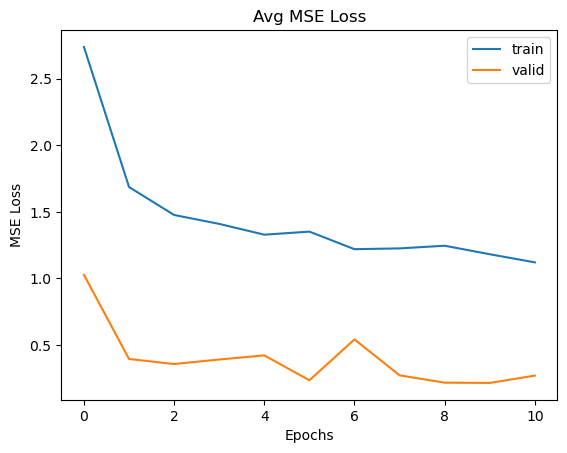

In [20]:
plt.plot(avg_train_metrics['losses'], label='train')
plt.plot(avg_valid_metrics['losses'], label='valid')
plt.title('Avg MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend();

Load best model

In [22]:
# weights_path = r'C:\\Users\\itber\\Documents\\learning\\self_tutorials\\CV_projects\\mars_challenge\\models\\model_9.pth'
model.load_state_dict(torch.load(model_savepath));

## Test Loop

In [23]:
model.eval()

test_metrics = {
        'losses' : AverageMeter()
    }


with torch.no_grad():
    for i, ((image1, image2), speed) in enumerate(test_loader):
        image1, image2, speed = image1.to(DEVICE), image2.to(DEVICE), speed.to(DEVICE)

        # pad to ensure that it is divisible by 8
        padder = InputPadder(image1.shape, mode=None)
        image1, image2 = padder.pad(image1, image2)

        # get predictions
        pred_speed = model(image1, image2)

        # compute losses
        loss = criterion(pred_speed, speed)

        # store metrics
        test_metrics['losses'].update(loss.item())

        if i % 50 == 0:
            print(f"test: epoch {e} - MSE loss: {valid_metrics['losses'].avg}")

test: epoch 11 - MSE loss: 0.2689
test: epoch 11 - MSE loss: 0.2689
test: epoch 11 - MSE loss: 0.2689


c:\Users\itber\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [24]:
test_metrics['losses'].avg

0.2351

In [30]:
(image1, image2), speed = next(iter(test_loader))

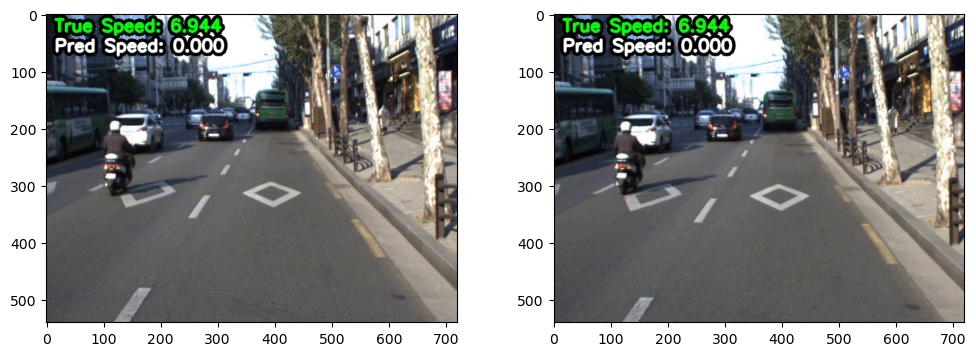

In [31]:
idx = 0

_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(viz(image1[idx, :, :, :].squeeze(), speed[idx], 0))
ax[1].imshow(viz(image2[idx, :, :, :].squeeze(), speed[idx], 0))

In [33]:
_valid_dataset.image_path1, _valid_dataset.image_path2

('C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_882.png',
 'C:\\Users\\itber\\Documents\\datasets\\mars_auto\\train\\frame_883.png')